Import Libraries

In [1]:
import os
import itertools

In [2]:
from seaborn import color_palette

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

In [4]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [5]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [6]:
from source.analysis import (
    read_data,
    preprocess,
    train,
    test,
    predict,
    get_graph_embeddings,
    pepvecs_2d_plot,
    get_kmeans_clusters,
    train_model,
    get_subseq_activations
)

from settings import DATA_DIR, AMINO_ACIDS

In [7]:
from source.models import BitterGCN_MixedPool
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [8]:
# Settings
hidden_channels = 16
epochs = 10

In [9]:
# Read data and preprocess it
df = read_data(DATA_DIR)
labels = df.bitter
seq = df.seq.values
protien_graphs, encoder = preprocess(df)
protien_graphs[0:5]

[Data(x=[3, 20], edge_index=[2, 4], y=1),
 Data(x=[10, 20], edge_index=[2, 18], y=1),
 Data(x=[4, 20], edge_index=[2, 6], y=1),
 Data(x=[8, 20], edge_index=[2, 14], y=1),
 Data(x=[2, 20], edge_index=[2, 2], y=1)]

### Train the model
Here we are using the GCN having three convolution layers and mixed pooling schema.

BitterGCN: 
 BitterGCN_MixedPool(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)
Epoch: 000, Accuracy: 0.6792
Epoch: 001, Accuracy: 0.7778
Epoch: 002, Accuracy: 0.8169
Epoch: 003, Accuracy: 0.8294
Epoch: 004, Accuracy: 0.8372
Epoch: 005, Accuracy: 0.8529
Epoch: 006, Accuracy: 0.8764
Epoch: 007, Accuracy: 0.8560
Epoch: 008, Accuracy: 0.8842
Epoch: 009, Accuracy: 0.8936


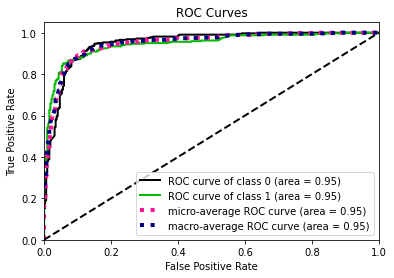

In [10]:
model = BitterGCN_MixedPool(hidden_channels=hidden_channels)
print("BitterGCN: \n", model)
optimizer = Adam(model.parameters(), lr=0.05)

criterion = CrossEntropyLoss()

model, train_loader, test_loader = train_model(model, protien_graphs, optimizer, criterion, epochs=10)

## Analysis

KL Div: 0.30877381563186646


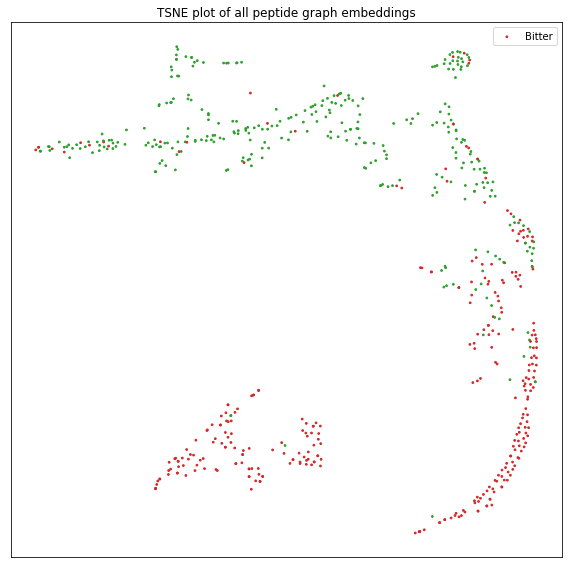

In [11]:
train_graph_embeddings=get_graph_embeddings(model, train_loader, encoder)
test_graph_embeddings=get_graph_embeddings(model, test_loader, encoder)
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings
tsne_embd, descs, labels = pepvecs_2d_plot(all_graph_embeddings)

Clusters

In [12]:
from seaborn import scatterplot
from sklearn.cluster import KMeans

Least Bitter Cluster ----> Most Bitter Cluster
----------------------------------------------
   Cluster-1  Cluster-2  Cluster-3  Cluster-4
A       0.09       0.06       0.01       0.00
C       0.01       0.00       0.00       0.00
D       0.01       0.02       0.02       0.00
E       0.02       0.03       0.07       0.00
F       0.04       0.07       0.08       0.24
G       0.04       0.06       0.18       0.21
H       0.05       0.02       0.01       0.00
I       0.08       0.06       0.07       0.07
K       0.10       0.03       0.01       0.00
L       0.08       0.10       0.14       0.00
M       0.02       0.01       0.00       0.00
N       0.02       0.04       0.03       0.00
P       0.19       0.18       0.13       0.28
Q       0.09       0.07       0.03       0.00
R       0.03       0.04       0.02       0.12
S       0.04       0.03       0.01       0.00
T       0.01       0.04       0.00       0.00
V       0.03       0.07       0.10       0.05
W       0.02       0.01       0.

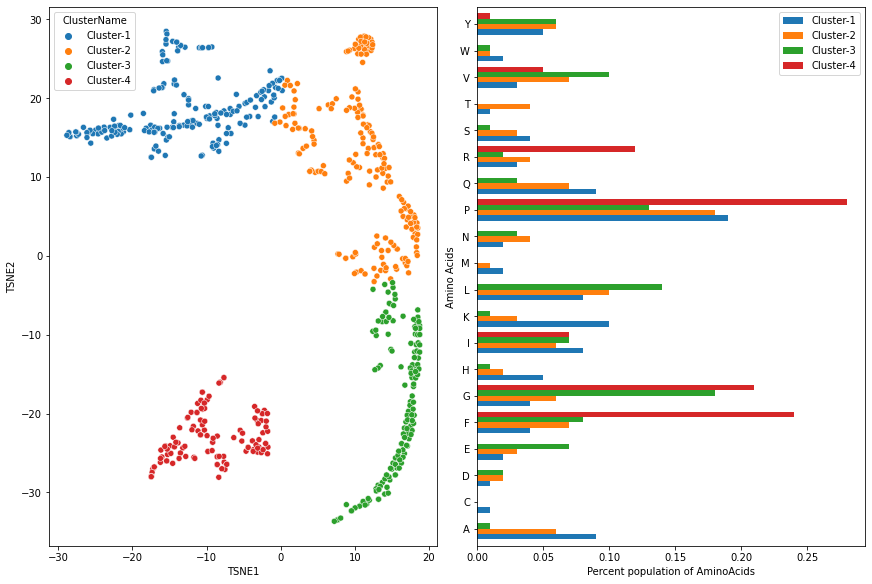

In [13]:
clusters, kmeans_embd, aminoacid_pop_in_clusters = get_kmeans_clusters(tsne_embd, descs, all_graph_embeddings)

pop=clusters[['desc', 'Cluster']]
pop.desc = pop.desc.apply(lambda x: [i for i in x])
print("Least Bitter Cluster ----> Most Bitter Cluster")
print("----------------------------------------------")
print(aminoacid_pop_in_clusters.round(2), '\n\n')
print("Accuracy and bitter population in the clusters")
print(clusters.groupby('Cluster').agg(n_bitterpeps=('label', sum), total_peps=('label',len), ModelAcc=('acc','mean')).round(2))

## Node level embeddings: All Data 

##### Amino-acid level (Mono-pep)

Text(0.5, 1.0, 'Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors')

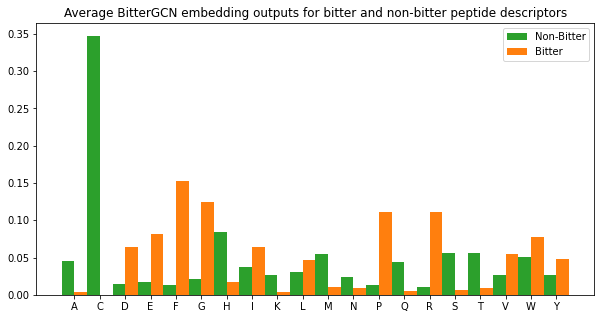

In [14]:
# Mono-peptides
# Avg
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=1)
monopeps = pd.DataFrame([subseqs, avg_importance], index=['pep', 'Imp']).T

# Pos
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=1)
posavg_importance = np.abs(posavg_importance)
posmonopeps = pd.DataFrame([subseqs, posavg_importance], index=['pep', 'Imp']).T

# Neg
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=1)
negmonopeps = pd.DataFrame([subseqs, negavg_importance], index=['pep', 'Imp']).T

# Plot 
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(x=np.arange(20)-0.25, height = np.abs(negmonopeps.Imp)/sum(np.abs(negmonopeps.Imp)), width=-.5, color=sns.color_palette()[2])
ax.bar(x=np.arange(20)+0.25, height = np.abs(posmonopeps.Imp)/sum(np.abs(posmonopeps.Imp)), width=-.5, color=sns.color_palette()[1])
ax.set_xticks(np.arange(20), AMINO_ACIDS)
ax.legend(['Non-Bitter', 'Bitter'])
ax.set_title('Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors')

In [15]:
# Di-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=2)
dipeps = pd.DataFrame([subseqs, avg_importance]).T
dipeps.columns = ['pep', 'Imp']

# Pos Di-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=2)
posdipeps = pd.DataFrame([possubseqs, posavg_importance]).T
posdipeps.columns = ['pep', 'Imp']

# Neg Di-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=2)
negdipeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negdipeps.columns = ['pep', 'Imp']


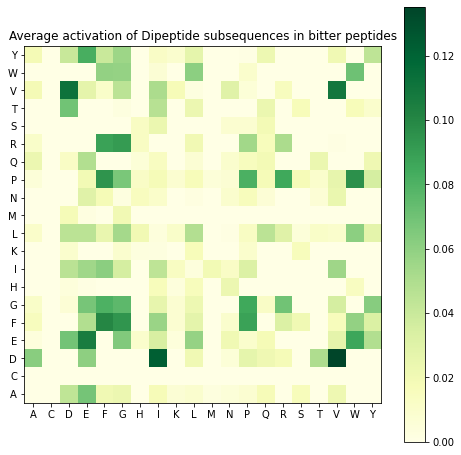

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(np.reshape(np.abs(posdipeps['Imp'].to_list()), (20,20))),cmap='YlGn')
plt.xticks(np.arange(20), AMINO_ACIDS, minor=False)
plt.yticks(np.arange(20), AMINO_ACIDS[::-1])
plt.title("Average activation of Dipeptide subsequences in bitter peptides")
plt.colorbar()


In [17]:
# Tri-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=3)
tripeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tripeps.columns = ['pep', 'Imp']
tripeps.sort_values(by='Imp', ascending=True)

# Pos Tri-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=3)
postripeps = pd.DataFrame([possubseqs, posavg_importance]).T
postripeps.columns = ['pep', 'Imp']

# Neg Tri-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=3)
negtripeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtripeps.columns = ['pep', 'Imp']


In [18]:
# Tetra-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=4)
tetrapeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tetrapeps.columns = ['pep', 'Imp']
tetrapeps.sort_values(by='Imp', ascending=False)

# Pos Tetra-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=4)
postetrapeps = pd.DataFrame([possubseqs, posavg_importance]).T
postetrapeps.columns = ['pep', 'Imp']

# Neg Tetra-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=4)
negtetrapeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtetrapeps.columns = ['pep', 'Imp']


In [19]:
posallsubpeps = posdipeps.append(posmonopeps).append(postripeps).append(postetrapeps)

posallsubpeps['Imp'] = np.abs(posallsubpeps['Imp'])/np.sum(np.abs(posallsubpeps['Imp']))
posallsubpeps['len'] = posallsubpeps['pep'].apply(len)
posallsubpeps=posallsubpeps[posallsubpeps.Imp!=0]

In [20]:
negallsubpeps = negdipeps.append(negmonopeps).append(negtripeps).append(negtetrapeps)

negallsubpeps['Imp'] = np.abs(negallsubpeps['Imp'])/np.sum(np.abs(negallsubpeps['Imp']))
negallsubpeps['len'] = negallsubpeps['pep'].apply(len)
negallsubpeps=negallsubpeps[negallsubpeps.Imp!=0]

In [21]:
allsubpeps = dipeps.append(monopeps).append(tripeps).append(tetrapeps)

allsubpeps['Imp'] = np.abs(allsubpeps['Imp'])/np.sum(np.abs(allsubpeps['Imp']))
allsubpeps['len'] = allsubpeps['pep'].apply(len)
allsubpeps=allsubpeps[allsubpeps.Imp!=0]

In [22]:
descs_qvals = pd.read_csv('data/Qvalues.csv', sep=', ')
delf=descs_qvals.set_index('Desc').FreeEnergy.to_dict()

In [23]:
def get_q(x): 
    try:
        return np.int(sum([delf[i] for i in x])/len(x))
    except:
        return None

In [24]:
posallsubpeps['Qval'] = posallsubpeps.pep.apply(lambda x: get_q(x))
posallsubpeps['Present'] = posallsubpeps.pep.isin(df.seq)
negallsubpeps['Qval'] = negallsubpeps.pep.apply(lambda x: get_q(x))
negallsubpeps['Present'] = negallsubpeps.pep.isin(df.seq)
allsubpeps['Qval'] = allsubpeps.pep.apply(lambda x: get_q(x))
allsubpeps['Present'] = allsubpeps.pep.isin(df.seq)


In [25]:
posallsubpeps.shape

(927, 5)

In [26]:
negallsubpeps.shape

(1315, 5)

In [27]:
posallsubpeps.sort_values('Imp',ascending=False)

,pep,Imp,len,Qval,Present
1844,FPF,0.004427,3,2633.0,True
342,VD,0.004373,2,1115.0,True
37044,FPPF,0.003994,4,2625.0,False
142,ID,0.003961,2,1755.0,True
100885,PPFG,0.00372,4,1962.0,False
...,...,...,...,...,...
2647,HPI,0.000008,3,NaN,False
2966,IKH,0.000008,3,NaN,False
98966,PIKH,0.000005,4,NaN,False
158440,YTDA,0.000005,4,1145.0,False


In [28]:
from scipy import stats

In [29]:
stats.ttest_ind(posallsubpeps.Imp, negallsubpeps.Imp)

Ttest_indResult(statistic=8.916090972310148, pvalue=9.78967790355256e-19)

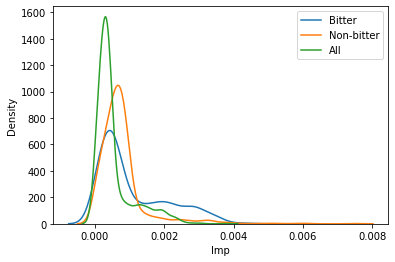

In [30]:
sns.kdeplot(posallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(negallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(allsubpeps.Imp.reset_index(drop=True))

plt.legend(['Bitter','Non-bitter','All'])

In [31]:
df['Qval']=df.seq.apply(lambda x: get_q(x))

<AxesSubplot:xlabel='Qval', ylabel='Density'>

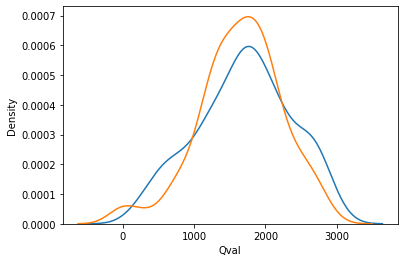

In [32]:
sns.kdeplot(df[df.bitter==1].reset_index(drop=False).Qval)
sns.kdeplot(df[df.bitter==0].reset_index(drop=False).Qval)

In [33]:
clusters['Imp']=clusters.conv3_feats.apply(lambda x: x.mean())

<AxesSubplot:xlabel='Imp', ylabel='Density'>

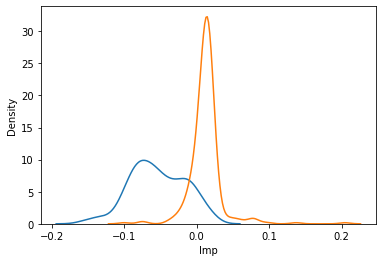

In [34]:
sns.kdeplot(clusters[clusters.label==1].Imp)
sns.kdeplot(clusters[clusters.label==0].Imp)

In [35]:
clusters

,desc,n_nodes,label,pred,conv3_feats,avg_desc_act,TSNE1,TSNE2,Cluster,acc,kmeansbitter,ClusterName,Imp
413,GKKIATYQER,10,0,0,"[[0.0511165, -0.014255837, 0.002711161, -0.166...","[0.006568294, 0.0019829823, 0.004785656, 0.011...",-8.327675,14.725888,1.0,1,1,Cluster-1,0.012395
390,SG,2,0,0,"[[-0.0050193816, -0.029525947, 0.00035626325, ...","[0.015661553, 0.015661553]",-9.951436,17.431004,1.0,1,1,Cluster-1,0.015662
150,HL,2,0,0,"[[-0.15039615, 0.004667286, -0.11869371, -0.26...","[0.08441653, 0.08441653]",-14.565522,27.207483,1.0,1,1,Cluster-1,0.084417
152,MKG,3,0,0,"[[-0.048982553, -0.0023036376, -0.06150494, -0...","[0.046803236, 0.04316662, 0.03165739]",-15.241479,24.713314,1.0,1,1,Cluster-1,0.040542
566,KAVPYPPQ,8,1,0,"[[0.06064683, -0.011663392, 0.0031109583, -0.1...","[0.005024504, 0.008452724, 0.01867755, 0.01861...",-15.2142,15.070912,1.0,0,2,Cluster-1,0.009825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,RGPPGGF,7,1,1,"[[0.20819475, 0.27039897, 0.16207689, 0.048988...","[-0.071188025, -0.08903428, -0.08353744, -0.08...",-10.239233,-20.963455,4.0,1,8,Cluster-4,-0.081902
378,GR,2,1,1,"[[0.26199126, 0.29366618, 0.19258435, 0.083802...","[-0.08772232, -0.08772232]",-10.811689,-22.693529,4.0,1,8,Cluster-4,-0.087722
385,VYPFPPGIGG,10,1,1,"[[0.067754865, 0.00027096272, 0.06699507, -0.0...","[-0.013243782, -0.037870467, -0.077905506, -0....",-3.027979,-21.286781,4.0,1,8,Cluster-4,-0.066746
349,YPFPGPI,7,1,1,"[[0.177754, 0.18900125, 0.13978295, 0.03349171...","[-0.057015736, -0.09285597, -0.11420613, -0.10...",-3.468994,-20.564188,4.0,1,8,Cluster-4,-0.066763


In [36]:
clusters.to_csv('final_res.csv')